In [1]:
from fpm_phage import model, integrate, viz
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from tqdm import tqdm

consts=model.load_constants()

### Setup and ODE integration

In [2]:
phi_O=consts['phi_O']
print(phi_O)

0.55


In [3]:
# Load constants and parameters
phi_O=consts['phi_O']
gamma_max=consts['gamma_max']
Kd_cpc=consts['Kd_cpc']
Kd_cnt=consts['Kd_cnt']
Y=consts['Y']
nu_max=20
consts['nu_max']=nu_max
f_a=1
m_Rb=consts['m_Rb']
m_phage=30*10**6/110 # Dalton mass of viral proteome / (Dalton mass of 1 a.a.)


In [4]:
equil

NameError: name 'equil' is not defined

In [15]:
# Set inital steady state conditions
phi_O_ss=consts['phi_O']
phi_Rb_ss=model.phiRb_optimal_allocation(gamma_max,nu_max,Kd_cpc,phi_O_ss)
phi_Mb_ss=1-phi_O-phi_Rb_ss
phi_O=consts['phi_O']
M0=1e9
c_nt=1

# ppGpp params
Kd_TAA = consts['Kd_TAA']
Kd_TAA_star = consts['Kd_TAA_star']
tau = consts['tau'] 
kappa_max = consts['kappa_max']
phi_Ph_vals=np.linspace(0,1-phi_O,11) # Generate Phi phage values

# Pre-infection arguments
preinf_args = {'gamma_max':gamma_max,
                      'nu_max':nu_max,
                      'Kd_TAA':Kd_TAA,
                      'Kd_TAA_star':Kd_TAA_star,
                      'kappa_max':kappa_max,
                      'tau':tau,
                      'phi_O':phi_O_ss,
                      'phi_Ph':0,
                      'nutrients':{'Kd_cnt':consts['Kd_cnt'],'Y':consts['Y'],'c_nt':c_nt},
                      'Kd_cnt':consts['Kd_cnt'],
                      'Y':consts['Y'],
                      'dynamic_phiRb':True,
                      'phiRb': phi_Rb_ss,
                      'tRNA_regulation':True,
                      'f_a':1,
                      'dil_approx':False}

equil = integrate.equilibrate_FPM(preinf_args)
equil_TAA_star = equil[-1]
equil_TAA = equil[-2]
equil_phiRb = equil[1] / equil[0]
equil_phiMb=1-phi_O-equil_phiRb

init_params = [M0,M0*equil_phiRb,M0*equil_phiMb,0,c_nt,equil_TAA_star,equil_TAA]


# Integrate ODEs for each phi_Ph value
out_vars=['M','M_Rb','M_Mb','M_Ph','c_nt','T_AA_star','T_AA'] # variable names for the variables integrated over time
out=[]
for phi_Ph in phi_Ph_vals:
    postinf_args = {'gamma_max':gamma_max,
                      'nu_max':nu_max,
                      'Kd_TAA':Kd_TAA,
                      'Kd_TAA_star':Kd_TAA_star,
                      'kappa_max':kappa_max,
                      'tau':tau,
                      'phi_O':phi_O,
                      'phi_Ph':phi_Ph,
                      'nutrients':{'Kd_cnt':consts['Kd_cnt'],'Y':consts['Y'],'c_nt':c_nt},
                      'Kd_cnt':consts['Kd_cnt'],
                      'Y':consts['Y'],
                      'dynamic_phiRb':True,
                      'tRNA_regulation':True,
                      'f_a':1,
                      'dil_approx':False,
                      'ansatz':'binding'}

    # Set new allocations proportionally to initial SS optimal allocation

    # Integration parameters
    max_time = 30
    dt=0.000001
    

    # Perform integration and store results in out
    time = np.arange(0, max_time, dt)
    out += [scipy.integrate.odeint(model.self_replicator_FPM_lytic_phage, 
                    init_params, 
                    time,args=(postinf_args,))]

In [16]:
# Create dataframe to store results of ODE integration
df=pd.DataFrame()
for i in range(len(phi_Ph_vals)):
    _df=pd.DataFrame()
    _df['time']=np.linspace(0,max_time,int(np.round(max_time/dt,0)/100))
    for j in range(len(out_vars)):
        _df[out_vars[j]]=out[i][::100,j]
    _df['phi_Ph_val']=phi_Ph_vals[i]
    df=pd.concat([df,_df])

# Print dataframe column names
df.columns

Index(['time', 'M', 'M_Rb', 'M_Mb', 'M_Ph', 'c_nt', 'T_AA_star', 'T_AA',
       'phi_Ph_val'],
      dtype='object')

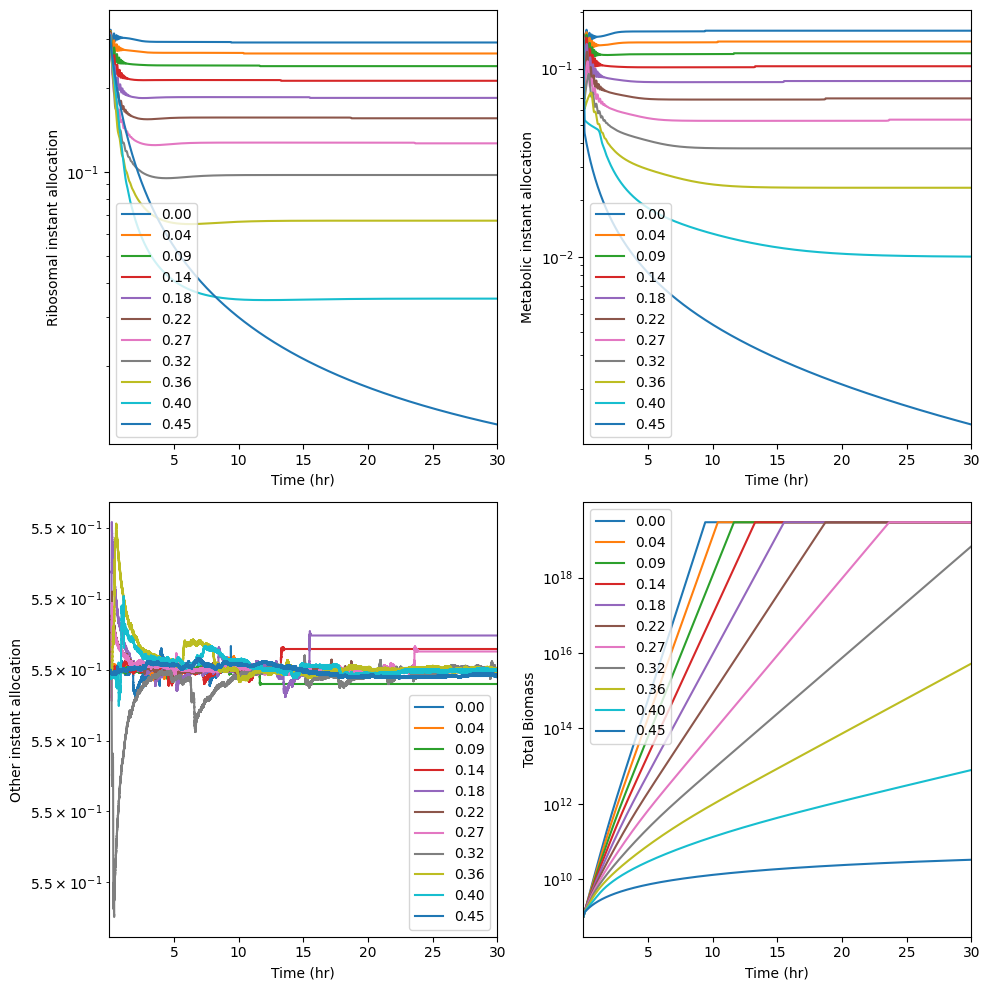

In [17]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M_Rb/df.loc[df.phi_Ph_val==phi].M
    plt.plot(x_val,y_val,label='%.2f'%phi)
# x_val2=df.time
# y_val2=df.M_Rb/df.M
# plt.plot(x_val2,y_val2,'k',label='no phage')
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Ribosomal instant allocation')
plt.yscale('log')
plt.xlim([1e-2,3e1]);


plt.subplot(2,2,2)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M_Mb/df.loc[df.phi_Ph_val==phi].M
    plt.plot(x_val,y_val,label='%.2f'%phi)
# x_val2=df.time
# y_val2=df.M_Mb/df.M
# plt.plot(x_val2,y_val2,'k',label='no phage')
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Metabolic instant allocation')
plt.yscale('log')
plt.xlim([1e-2,3e1]);

plt.subplot(2,2,3)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=(df.loc[df.phi_Ph_val==phi].M-df.loc[df.phi_Ph_val==phi].M_Mb-df.loc[df.phi_Ph_val==phi].M_Rb-df.loc[df.phi_Ph_val==phi].M_Ph)/df.loc[df.phi_Ph_val==phi].M
    plt.plot(x_val,y_val,label='%.2f'%phi)
# x_val2=df.time
# y_val2=(df.M-df.M_Mb-df.M_Rb)/df.M
# plt.plot(x_val2,y_val2,'k',label='no phage')
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Other instant allocation')
plt.yscale('log')
plt.xlim([1e-2,3e1]);

plt.subplot(2,2,4)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M
    plt.plot(x_val,y_val,label='%.2f'%phi)
# x_val2=df.time
# y_val2=df.M
# plt.plot(x_val2,y_val2,'k',label='no phage')
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Total Biomass')
plt.yscale('log')
plt.xlim([1e-2,3e1]);

plt.tight_layout()

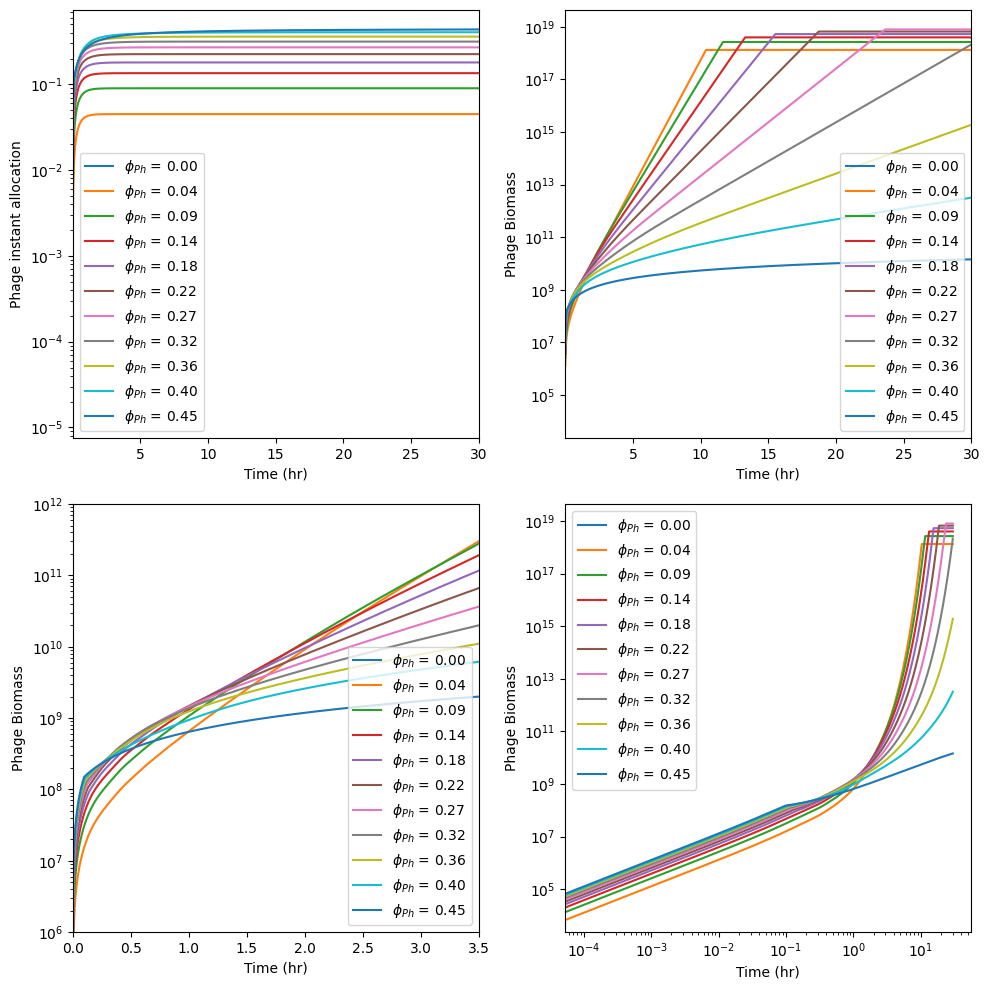

In [18]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M_Ph/df.loc[df.phi_Ph_val==phi].M
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.2f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage instant allocation')
plt.yscale('log')
plt.xlim([1e-2,3e1]);


plt.subplot(2,2,2)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.2f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.xlim([1e-2,3e1]);

plt.subplot(2,2,3)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.2f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.ylim([1e6,1e12])
plt.xlim([0,3.5]);

plt.subplot(2,2,4)
for phi in phi_Ph_vals:
    x_val=df.loc[df.phi_Ph_val==phi].time
    y_val=df.loc[df.phi_Ph_val==phi].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.2f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e6,1e12])

plt.tight_layout()

100%|██████████| 9/9 [00:32<00:00,  3.58s/it]


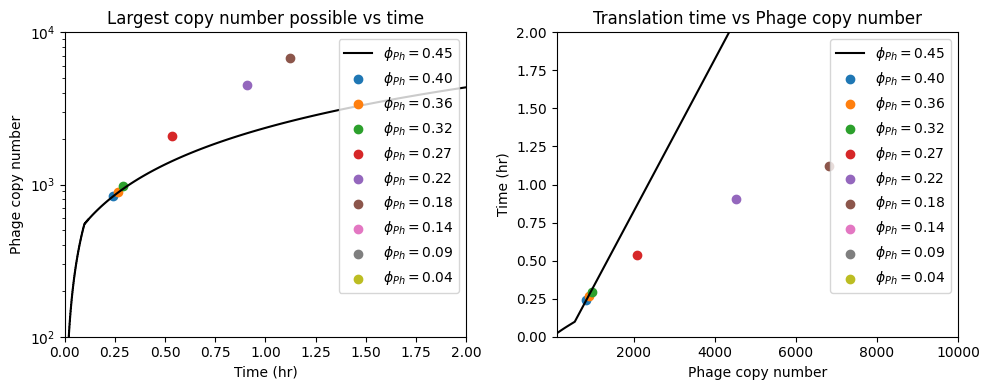

In [20]:
plt.figure(figsize=(10,4))

burst_size_match = []
time_match = []
phi_val = []
phi_prev=0.45
phi_Ph_vals_reverse=phi_Ph_vals[::-1]
for phi in tqdm(phi_Ph_vals_reverse[1:-1]):
    df_prev_phi=df.loc[np.round(df.phi_Ph_val,3)==np.round(phi_prev,3)]
    df_current_phi=df.loc[np.round(df.phi_Ph_val,3)==np.round(phi,3)]
    for t_ in df.time.unique()[1:]:
        if df_current_phi.loc[df_current_phi.time==t_].M_Ph.values > df_prev_phi.loc[df_prev_phi.time==t_].M_Ph.values: # Check if current allocation has surpassed previous allocation in terms of phage biomass
            burst_size_match +=[df_current_phi.loc[df_current_phi.time==t_].M_Ph//m_phage]
            time_match +=[t_]
            phi_val +=[phi]
            phi_prev=phi
            break

plt.subplot(1,2,1)
x_val=df.time.unique()
y_val=df.loc[df.phi_Ph_val>0.44].M_Ph//m_phage
plt.plot(x_val,y_val,color='k',label='$\phi_{Ph} = 0.45$') # plot curve for phi = 1 strategy
for i in range(len(time_match)):
    plt.scatter(time_match[i],burst_size_match[i],label='$\phi_{Ph} = %.2f$'%(phi_val[i])) # Plot individual points for 

plt.xlabel('Time (hr)')
plt.ylabel('Phage copy number')
plt.title('Largest copy number possible vs time')
plt.yscale('log')
plt.ylim([1e2,1e4])
plt.xlim([0,2])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(y_val,x_val,color='k',label='$\phi_{Ph} = 0.45$') # Reverse x and y axes
for i in range(len(time_match)):
    plt.scatter(burst_size_match[i],time_match[i],label='$\phi_{Ph} = %.2f$'%(phi_val[i]))

plt.ylabel('Time (hr)')
plt.xlabel('Phage copy number')
plt.title('Translation time vs Phage copy number')
plt.xlim([1e2,1e4])
plt.ylim([0,2])
plt.legend()

plt.tight_layout()

### Rescaling nu max with phi phage

In [ ]:
# Set inital steady state conditions
phi_O_ss=consts['phi_O']
phi_Rb_ss=model.phiRb_optimal_allocation(gamma_max,nu_max,Kd_cpc,phi_O_ss)
phi_Mb_ss=1-phi_O-phi_Rb_ss
phi_O=consts['phi_O']
M0=1e9
c_nt=1

# ppGpp params
Kd_TAA = consts['Kd_TAA']
Kd_TAA_star = consts['Kd_TAA_star']
tau = consts['tau'] 
kappa_max = consts['kappa_max']
phi_Ph_vals=np.linspace(0,1-phi_O,11) # Generate Phi phage values

# Pre-infection arguments
preinf_args = {'gamma_max':gamma_max,
                      'nu_max':nu_max,
                      'Kd_TAA':Kd_TAA,
                      'Kd_TAA_star':Kd_TAA_star,
                      'kappa_max':kappa_max,
                      'tau':tau,
                      'phi_O':phi_O_ss,
                      'phi_Ph':0,
                      'nutrients':{'Kd_cnt':consts['Kd_cnt'],'Y':consts['Y'],'c_nt':c_nt},
                      'Kd_cnt':consts['Kd_cnt'],
                      'Y':consts['Y'],
                      'dynamic_phiRb':True,
                      'phiRb': phi_Rb_ss,
                      'tRNA_regulation':True,
                      'f_a':1,
                      'dil_approx':False}

equil = integrate.equilibrate_FPM(preinf_args)
equil_TAA_star = equil[-1]
equil_TAA = equil[-2]
equil_phiRb = equil[1] / equil[0]
equil_phiMb=1-phi_O-equil_phiRb

init_params = [M0,M0*equil_phiRb,M0*equil_phiMb,0,c_nt,equil_TAA_star,equil_TAA]


# Integrate ODEs for each phi_Ph value
out_vars=['M','M_Rb','M_Mb','M_Ph','c_nt','T_AA_star','T_AA'] # variable names for the variables integrated over time
out=[]
for phi_Ph in phi_Ph_vals:
    postinf_args = {'gamma_max':gamma_max,
                      'nu_max':nu_max,
                      'Kd_TAA':Kd_TAA,
                      'Kd_TAA_star':Kd_TAA_star,
                      'kappa_max':kappa_max,
                      'tau':tau,
                      'phi_O':phi_O,
                      'phi_Ph':phi_Ph,
                      'nutrients':{'Kd_cnt':consts['Kd_cnt'],'Y':consts['Y'],'c_nt':c_nt},
                      'Kd_cnt':consts['Kd_cnt'],
                      'Y':consts['Y'],
                      'dynamic_phiRb':True,
                      'tRNA_regulation':True,
                      'f_a':1,
                      'dil_approx':False,
                      'ansatz':'binding'}

    # Set new allocations proportionally to initial SS optimal allocation

    # Integration parameters
    max_time = 30
    dt=0.000001
    

    # Perform integration and store results in out
    time = np.arange(0, max_time, dt)
    out += [scipy.integrate.odeint(model.self_replicator_FPM_lytic_phage_2, 
                    init_params, 
                    time,args=(postinf_args,))]

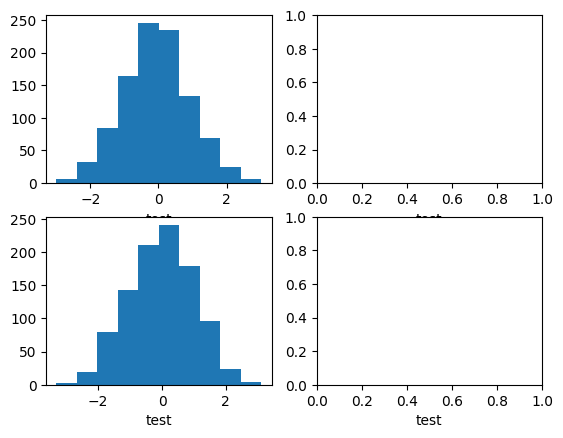

In [227]:

fig, ax = plt.subplots(2, 2)

for i in range(2):
    ax[i, 0].hist(np.random.normal(0, 1, 1000))

for a in ax.ravel():
    a.set_xlabel('test')